# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [ ]:
cabinetry.set_logging()

In [8]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.8
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

# Define the minimum bin counts
bin_threshold = 1


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

In [9]:
# load templates
samples = {r'$D\tau\nu$': ['MC14ri_sigDDst_foldex_e_7/D_tau_nu.root'],
         r'$D^\ast\tau\nu$': ['MC14ri_sigDDst_foldex_e_7/Dst_tau_nu.root'],
         r'$D^{\ast\ast}\tau\nu$': ['MC14ri_DststTau1_foldex_e_7/Dstst_tau_nu.root',
                        'MC14ri_DststTau2_foldex_e_7/Dstst_tau_nu.root'],
         
         r'$D\ell\nu$': ['MC14ri_normDDst_foldex_e_7/D_ell_nu.root'],
         r'$D^\ast\ell\nu$': ['MC14ri_normDDst_foldex_e_7/Dst_ell_nu.root'],
         r'$D^{\ast\ast}\ell\nu$': ['MC14ri_normDDst_foldex_e_7/Dstst_ell_nu.root',
                        'MC14ri_Dststell2_foldex_e_7/Dstst_ell_nu.root'] }

templates = {}
for name, fs in samples.items():
    templates[name] = uproot.concatenate([f'../Samples/Signal_MC14ri/{f}:template' for f in fs],library="pd")
    
files_flat = [item for sublist in samples.values() for item in sublist]
data = uproot.concatenate([f'../Samples/Signal_MC14ri/{f}:test' for f in files_flat],library="pd")

In [21]:
# Create template histograms
t_histograms = {}
t_staterr = {}
for name, template in templates.items():
    
    (counts, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr[name] = np.sqrt(staterr_squared).T
    t_histograms[name] = counts.T
    
# Create data histogram
(d_histogram, xedges, yedges) = np.histogram2d(data['B0_CMS3_weMissM2'], 
                                               data['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins])
d_histogram = d_histogram.T
    
indices_threshold = np.where(np.sum(list(t_histograms.values()),axis=0) >= bin_threshold)
template_flat = {name:list(t[indices_threshold]) for name,t in t_histograms.items()}
staterr_flat = {name:list(se[indices_threshold]) for name,se in t_staterr.items()}
# data = counts.ravel().to_list()
data_flat = list(d_histogram[indices_threshold])

# edges = np.linspace(0, len(data), len(data)+1)
# truth = np.array([int(np.sum(t0)) for t0 in test0])


# 2. Create a pyhf workspace

In [2]:
workspace_path = "R_D_2d_workspace.json"
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        1.0,
                        1.0,
                        0.0,
                        0.0,
                        1.0,
                        0.0,
                        4.0,
                        1.0,
                        1.0,
                        5.0,
                        5.0,
                        9.0,
                        5.0,
                        0.0,
                        0.0,
                        2.0,
                        1.0,
                        1.0,
                        2.0,
                        1.0,
                        4.0,
                        6.0,
                        8.0,
                        9.0,
                        11.0,
                        7.0,
                        5.0,
                        1.0,
                        1.0,
                  

In [22]:
# update templates and data in the workspace
for i in spec['channels'][0]['samples']:
    i['data'] = template_flat[i['name']]
    for m in i['modifiers']:
        if m['type']=='staterror':
            m['data'] = staterr_flat[i['name']]
spec['observations'][0]['data']=data_flat

print(json.dumps(spec, sort_keys=True, indent=4))

#cabinetry.workspace.save(spec, workspace_path)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (750 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


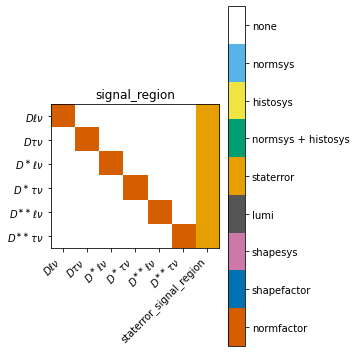

In [24]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [3]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (750 new nuisance parameters)


In [3]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit.pdf


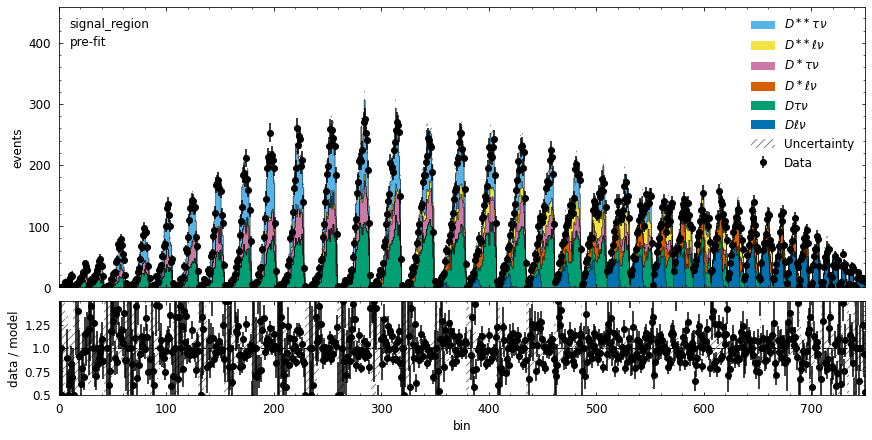

In [46]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
[dm] = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
dm['figure'].set_figwidth(12)

# 3. MLE

In [7]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data, minos=model.config.parameters[:6])

INFO - cabinetry.fit - performing maximum likelihood fit


W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.373899
W MnPosDef non-positive diagonal element in covariance matrix[ 71 ] = -0.156495
W MnPosDef non-positive diagonal element in covariance matrix[ 385 ] = -0.133467
W MnPosDef non-positive diagonal element in covariance matrix[ 705 ] = -0.133467
W MnPosDef non-positive diagonal element in covariance matrix[ 715 ] = -0.133467
W MnPosDef Added to diagonal of Error matrix a value 0.8739
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.420743
W MnPosDef non-positive diagonal element in covariance matrix[ 385 ] = -0.157372
W MnPosDef non-positive diagonal element in covariance matrix[ 705 ] = -0.157372
W MnPosDef non-positive diagonal element in covariance matrix[ 715 ] = -0.157372
W MnPosDef Added to diagonal of Error matrix a value 0.920744


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3456                       │            Nfcn = 605198             │
│ EDM = 7.99e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - running MINOS for $D\ell\nu

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement


INFO - cabinetry.fit - running MINOS for $D\tau\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00732825 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 0.00300206 is above tolerance 0.001
W MnMinos could not find Upper Value for Parameter $D\tau\nu$


INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$


W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.000249137 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 2.94549
W VariableMetricBuilder gdel = -0.00021152
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.0084439 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 0.0027571 is above tolerance 0.001
W MnMinos could not find Upper Value for Parameter $D^\ast\tau\nu$
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement


INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\ell\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00750375 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 0.00293513 is above tolerance 0.001
W MnMinos could not find Lower Value for Parameter $D^\ast\tau\nu$
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00117541 Requested 0.0001
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00446732 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 0.00446732 is above tolerance 0.001
W MnMinos could not find Upper Value for Parameter $D^{\ast\ast}\ell\nu$


INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00114734 Requested 0.0001
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00314309 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 0.00227007 is above tolerance 0.001
W MnMinos could not find Upper Value for Parameter $D^{\ast\ast}\tau\nu$


INFO - cabinetry.fit - MINOS results:


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00114582 Requested 0.0001


INFO - cabinetry.fit - $D\ell\nu$                   =  0.9828 -0.0264 +0.0266
INFO - cabinetry.fit - $D\tau\nu$                   =  0.9566 -0.0574 +0.0572
INFO - cabinetry.fit - $D^\ast\ell\nu$              =  1.0627 -0.0559 +0.0567
INFO - cabinetry.fit - $D^\ast\tau\nu$              =  1.0766 -0.1232 +0.1232
INFO - cabinetry.fit - $D^{\ast\ast}\ell\nu$        =  1.0159 -0.0811 +0.0814
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$        =  1.0131 -0.0682 +0.0679
DEBUG - cabinetry.fit - -2 log(L) = 3456.242524 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\ell\nu$                   =  0.9828 +/- 0.0264
INFO - cabinetry.fit - $D\tau\nu$                   =  0.9566 +/- 0.0572
INFO - cabinetry.fit - $D^\ast\ell\nu$              =  1.0627 +/- 0.0561
INFO - cabinetry.fit - $D^\ast\tau\nu$              =  1.0766 +/- 0.1232
INFO - cabinetry.fit - $D^{\ast\ast}\ell\nu$        =  1.0159 +/- 0.0814
INFO - cabinetry.fit - $D^{\ast\as

INFO - cabinetry.fit - staterror_signal_region[98]  =  0.8625 +/- 0.0730
INFO - cabinetry.fit - staterror_signal_region[99]  =  0.9793 +/- 0.0696
INFO - cabinetry.fit - staterror_signal_region[100] =  1.0393 +/- 0.0652
INFO - cabinetry.fit - staterror_signal_region[101] =  1.0581 +/- 0.0646
INFO - cabinetry.fit - staterror_signal_region[102] =  1.0436 +/- 0.0686
INFO - cabinetry.fit - staterror_signal_region[103] =  1.1617 +/- 0.0823
INFO - cabinetry.fit - staterror_signal_region[104] =  0.7671 +/- 0.0851
INFO - cabinetry.fit - staterror_signal_region[105] =  0.9733 +/- 0.1019
INFO - cabinetry.fit - staterror_signal_region[106] =  0.8350 +/- 0.2229
INFO - cabinetry.fit - staterror_signal_region[107] =  0.0000 +/- 6.3367
INFO - cabinetry.fit - staterror_signal_region[108] =  1.0076 +/- 0.4967
INFO - cabinetry.fit - staterror_signal_region[109] =  1.1365 +/- 0.4042
INFO - cabinetry.fit - staterror_signal_region[110] =  0.8089 +/- 0.2864
INFO - cabinetry.fit - staterror_signal_region[111]

INFO - cabinetry.fit - staterror_signal_region[211] =  0.7533 +/- 0.1614
INFO - cabinetry.fit - staterror_signal_region[212] =  0.9707 +/- 0.1550
INFO - cabinetry.fit - staterror_signal_region[213] =  1.1019 +/- 0.1288
INFO - cabinetry.fit - staterror_signal_region[214] =  0.8945 +/- 0.0961
INFO - cabinetry.fit - staterror_signal_region[215] =  1.0435 +/- 0.0829
INFO - cabinetry.fit - staterror_signal_region[216] =  0.9422 +/- 0.0700
INFO - cabinetry.fit - staterror_signal_region[217] =  0.9957 +/- 0.0639
INFO - cabinetry.fit - staterror_signal_region[218] =  1.0424 +/- 0.0580
INFO - cabinetry.fit - staterror_signal_region[219] =  1.0071 +/- 0.0539
INFO - cabinetry.fit - staterror_signal_region[220] =  0.9218 +/- 0.0469
INFO - cabinetry.fit - staterror_signal_region[221] =  1.0901 +/- 0.0481
INFO - cabinetry.fit - staterror_signal_region[222] =  0.9722 +/- 0.0455
INFO - cabinetry.fit - staterror_signal_region[223] =  1.0899 +/- 0.0493
INFO - cabinetry.fit - staterror_signal_region[224]

INFO - cabinetry.fit - staterror_signal_region[324] =  1.2443 +/- 0.3133
INFO - cabinetry.fit - staterror_signal_region[325] =  1.0318 +/- 0.2467
INFO - cabinetry.fit - staterror_signal_region[326] =  0.7388 +/- 0.2013
INFO - cabinetry.fit - staterror_signal_region[327] =  1.1743 +/- 0.1875
INFO - cabinetry.fit - staterror_signal_region[328] =  1.2536 +/- 0.1574
INFO - cabinetry.fit - staterror_signal_region[329] =  1.0126 +/- 0.1445
INFO - cabinetry.fit - staterror_signal_region[330] =  0.9321 +/- 0.1142
INFO - cabinetry.fit - staterror_signal_region[331] =  1.1091 +/- 0.1129
INFO - cabinetry.fit - staterror_signal_region[332] =  0.7905 +/- 0.0846
INFO - cabinetry.fit - staterror_signal_region[333] =  0.9963 +/- 0.0834
INFO - cabinetry.fit - staterror_signal_region[334] =  0.9829 +/- 0.0732
INFO - cabinetry.fit - staterror_signal_region[335] =  0.9333 +/- 0.0651
INFO - cabinetry.fit - staterror_signal_region[336] =  1.0747 +/- 0.0664
INFO - cabinetry.fit - staterror_signal_region[337]

INFO - cabinetry.fit - staterror_signal_region[437] =  0.8207 +/- 0.2358
INFO - cabinetry.fit - staterror_signal_region[438] =  1.0632 +/- 0.1883
INFO - cabinetry.fit - staterror_signal_region[439] =  1.0517 +/- 0.1384
INFO - cabinetry.fit - staterror_signal_region[440] =  1.1131 +/- 0.1358
INFO - cabinetry.fit - staterror_signal_region[441] =  1.0051 +/- 0.1192
INFO - cabinetry.fit - staterror_signal_region[442] =  1.1029 +/- 0.1065
INFO - cabinetry.fit - staterror_signal_region[443] =  0.8603 +/- 0.0904
INFO - cabinetry.fit - staterror_signal_region[444] =  1.0053 +/- 0.0850
INFO - cabinetry.fit - staterror_signal_region[445] =  1.1195 +/- 0.0792
INFO - cabinetry.fit - staterror_signal_region[446] =  0.9132 +/- 0.0714
INFO - cabinetry.fit - staterror_signal_region[447] =  1.0984 +/- 0.0728
INFO - cabinetry.fit - staterror_signal_region[448] =  1.1231 +/- 0.0759
INFO - cabinetry.fit - staterror_signal_region[449] =  1.0408 +/- 0.0715
INFO - cabinetry.fit - staterror_signal_region[450]

INFO - cabinetry.fit - staterror_signal_region[550] =  1.0605 +/- 0.0615
INFO - cabinetry.fit - staterror_signal_region[551] =  1.1369 +/- 0.0942
INFO - cabinetry.fit - staterror_signal_region[552] =  1.1470 +/- 0.4044
INFO - cabinetry.fit - staterror_signal_region[553] =  0.8474 +/- 0.1277
INFO - cabinetry.fit - staterror_signal_region[554] =  0.9296 +/- 0.1129
INFO - cabinetry.fit - staterror_signal_region[555] =  0.9908 +/- 0.1153
INFO - cabinetry.fit - staterror_signal_region[556] =  1.0327 +/- 0.0971
INFO - cabinetry.fit - staterror_signal_region[557] =  0.9773 +/- 0.0829
INFO - cabinetry.fit - staterror_signal_region[558] =  0.9868 +/- 0.0786
INFO - cabinetry.fit - staterror_signal_region[559] =  1.0631 +/- 0.0759
INFO - cabinetry.fit - staterror_signal_region[560] =  0.9838 +/- 0.0689
INFO - cabinetry.fit - staterror_signal_region[561] =  1.0336 +/- 0.0643
INFO - cabinetry.fit - staterror_signal_region[562] =  0.9964 +/- 0.0598
INFO - cabinetry.fit - staterror_signal_region[563]

INFO - cabinetry.fit - staterror_signal_region[663] =  1.0650 +/- 0.0954
INFO - cabinetry.fit - staterror_signal_region[664] =  1.4176 +/- 0.2504
INFO - cabinetry.fit - staterror_signal_region[665] =  1.1316 +/- 0.2134
INFO - cabinetry.fit - staterror_signal_region[666] =  0.9267 +/- 0.1261
INFO - cabinetry.fit - staterror_signal_region[667] =  0.8546 +/- 0.0983
INFO - cabinetry.fit - staterror_signal_region[668] =  1.0492 +/- 0.1032
INFO - cabinetry.fit - staterror_signal_region[669] =  0.9794 +/- 0.0843
INFO - cabinetry.fit - staterror_signal_region[670] =  1.0328 +/- 0.0772
INFO - cabinetry.fit - staterror_signal_region[671] =  1.0440 +/- 0.0682
INFO - cabinetry.fit - staterror_signal_region[672] =  0.9402 +/- 0.0641
INFO - cabinetry.fit - staterror_signal_region[673] =  1.0109 +/- 0.0652
INFO - cabinetry.fit - staterror_signal_region[674] =  0.9954 +/- 0.0860
INFO - cabinetry.fit - staterror_signal_region[675] =  0.9097 +/- 0.1016
INFO - cabinetry.fit - staterror_signal_region[676]

6min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
%%time
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data, minos=model.config.parameters[:6])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.38837
W MnPosDef non-positive diagonal element in covariance matrix[ 71 ] = -0.250801
W MnPosDef non-positive diagonal element in covariance matrix[ 385 ] = -0.11795
W MnPosDef non-positive diagonal element in covariance matrix[ 705 ] = -0.11795
W MnPosDef non-positive diagonal element in covariance matrix[ 715 ] = -0.11795
W MnPosDef Added to diagonal of Error matrix a value 0.888371


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3456                       │      Nfcn = 291520, Ngrad = 16       │
│ EDM = 7.52e-05 (Goal: 0.0002)    │           time = 125.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - running MINOS for $D\ell\nu

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - running MINOS for $D\tau\nu$


W VariableMetricBuilder No improvement in line search
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00110701 Requested 0.0001
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 1.81338e-05 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 0.602355
W VariableMetricBuilder gdel = -0.000200105


INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement


INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.0329918 Requested 0.0001
W VariableMetricBuilder No convergence; Edm 0.0121511 is above tolerance 0.001
W MnMinos could not find Upper Value for Parameter $D^\ast\tau\nu$


INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\ell\nu$


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00130493 Requested 0.0001
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.000108154 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.0552613
W MnPosDef non-positive diagonal element in covariance matrix[ 714 ] = -0.0102636
W MnPosDef Added to diagonal of Error matrix a value 0.555262
W VariableMetricBuilder gdel = -0.359575


INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$


W VariableMetricBuilder No improvement in line search
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.000330003 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 1.21611
W VariableMetricBuilder gdel = -6.91994e-05
W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$                   =  0.9827 -0.0263 +0.0267
INFO - cabinetry.fit - $D\tau\nu$                   =  0.9567 -0.0575 +0.0572
INFO - cabinetry.fit - $D^\ast\ell\nu$              =  1.0628 -0.0560 +0.0566
INFO - cabinetry.fit - $D^\ast\tau\nu$              =  1.0766 -0.1221 +0.1226
INFO - cabinetry.fit - $D^{\ast\ast}\ell\nu$        =  1.0159 -0.0811 +0.0820
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$        =  1.0131 -0.0682 +0.0675
DEBUG - cabinetry.fit - -2 log(L) = 3456.242530 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\ell\nu$                   =  0.9827 +/- 0.0264
INFO - cabinetry.fit - $D\tau\nu$                   =  0.9567 +/- 0.0571
INFO - cabinetry.fit - $D^\ast\ell\nu$              =  1.0628 +/- 0.0562
INFO - cabinetry.fit - $D^\ast\tau\nu$              =  1.0766 +/- 0.1226
INFO - cabinetry.fit - $D^{\ast\ast}\ell\nu$        =  1.0159 +/- 0.0

INFO - cabinetry.fit - staterror_signal_region[98]  =  0.8625 +/- 0.0730
INFO - cabinetry.fit - staterror_signal_region[99]  =  0.9793 +/- 0.0696
INFO - cabinetry.fit - staterror_signal_region[100] =  1.0393 +/- 0.0652
INFO - cabinetry.fit - staterror_signal_region[101] =  1.0581 +/- 0.0646
INFO - cabinetry.fit - staterror_signal_region[102] =  1.0436 +/- 0.0686
INFO - cabinetry.fit - staterror_signal_region[103] =  1.1617 +/- 0.0823
INFO - cabinetry.fit - staterror_signal_region[104] =  0.7671 +/- 0.0851
INFO - cabinetry.fit - staterror_signal_region[105] =  0.9733 +/- 0.1019
INFO - cabinetry.fit - staterror_signal_region[106] =  0.8350 +/- 0.2229
INFO - cabinetry.fit - staterror_signal_region[107] =  0.0000 +/- 6.3370
INFO - cabinetry.fit - staterror_signal_region[108] =  1.0076 +/- 0.4968
INFO - cabinetry.fit - staterror_signal_region[109] =  1.1365 +/- 0.4043
INFO - cabinetry.fit - staterror_signal_region[110] =  0.8089 +/- 0.2865
INFO - cabinetry.fit - staterror_signal_region[111]

INFO - cabinetry.fit - staterror_signal_region[211] =  0.7532 +/- 0.1614
INFO - cabinetry.fit - staterror_signal_region[212] =  0.9706 +/- 0.1550
INFO - cabinetry.fit - staterror_signal_region[213] =  1.1019 +/- 0.1288
INFO - cabinetry.fit - staterror_signal_region[214] =  0.8945 +/- 0.0961
INFO - cabinetry.fit - staterror_signal_region[215] =  1.0435 +/- 0.0829
INFO - cabinetry.fit - staterror_signal_region[216] =  0.9422 +/- 0.0700
INFO - cabinetry.fit - staterror_signal_region[217] =  0.9957 +/- 0.0639
INFO - cabinetry.fit - staterror_signal_region[218] =  1.0424 +/- 0.0580
INFO - cabinetry.fit - staterror_signal_region[219] =  1.0071 +/- 0.0539
INFO - cabinetry.fit - staterror_signal_region[220] =  0.9218 +/- 0.0469
INFO - cabinetry.fit - staterror_signal_region[221] =  1.0901 +/- 0.0480
INFO - cabinetry.fit - staterror_signal_region[222] =  0.9722 +/- 0.0454
INFO - cabinetry.fit - staterror_signal_region[223] =  1.0899 +/- 0.0493
INFO - cabinetry.fit - staterror_signal_region[224]

INFO - cabinetry.fit - staterror_signal_region[324] =  1.2443 +/- 0.3134
INFO - cabinetry.fit - staterror_signal_region[325] =  1.0318 +/- 0.2467
INFO - cabinetry.fit - staterror_signal_region[326] =  0.7387 +/- 0.2013
INFO - cabinetry.fit - staterror_signal_region[327] =  1.1743 +/- 0.1875
INFO - cabinetry.fit - staterror_signal_region[328] =  1.2536 +/- 0.1574
INFO - cabinetry.fit - staterror_signal_region[329] =  1.0126 +/- 0.1445
INFO - cabinetry.fit - staterror_signal_region[330] =  0.9321 +/- 0.1142
INFO - cabinetry.fit - staterror_signal_region[331] =  1.1091 +/- 0.1129
INFO - cabinetry.fit - staterror_signal_region[332] =  0.7905 +/- 0.0846
INFO - cabinetry.fit - staterror_signal_region[333] =  0.9962 +/- 0.0834
INFO - cabinetry.fit - staterror_signal_region[334] =  0.9829 +/- 0.0732
INFO - cabinetry.fit - staterror_signal_region[335] =  0.9333 +/- 0.0651
INFO - cabinetry.fit - staterror_signal_region[336] =  1.0747 +/- 0.0664
INFO - cabinetry.fit - staterror_signal_region[337]

INFO - cabinetry.fit - staterror_signal_region[437] =  0.8207 +/- 0.2359
INFO - cabinetry.fit - staterror_signal_region[438] =  1.0631 +/- 0.1883
INFO - cabinetry.fit - staterror_signal_region[439] =  1.0517 +/- 0.1384
INFO - cabinetry.fit - staterror_signal_region[440] =  1.1131 +/- 0.1358
INFO - cabinetry.fit - staterror_signal_region[441] =  1.0051 +/- 0.1192
INFO - cabinetry.fit - staterror_signal_region[442] =  1.1029 +/- 0.1065
INFO - cabinetry.fit - staterror_signal_region[443] =  0.8603 +/- 0.0904
INFO - cabinetry.fit - staterror_signal_region[444] =  1.0053 +/- 0.0850
INFO - cabinetry.fit - staterror_signal_region[445] =  1.1195 +/- 0.0792
INFO - cabinetry.fit - staterror_signal_region[446] =  0.9132 +/- 0.0714
INFO - cabinetry.fit - staterror_signal_region[447] =  1.0984 +/- 0.0728
INFO - cabinetry.fit - staterror_signal_region[448] =  1.1231 +/- 0.0758
INFO - cabinetry.fit - staterror_signal_region[449] =  1.0408 +/- 0.0715
INFO - cabinetry.fit - staterror_signal_region[450]

INFO - cabinetry.fit - staterror_signal_region[550] =  1.0604 +/- 0.0615
INFO - cabinetry.fit - staterror_signal_region[551] =  1.1369 +/- 0.0942
INFO - cabinetry.fit - staterror_signal_region[552] =  1.1470 +/- 0.4045
INFO - cabinetry.fit - staterror_signal_region[553] =  0.8474 +/- 0.1277
INFO - cabinetry.fit - staterror_signal_region[554] =  0.9296 +/- 0.1129
INFO - cabinetry.fit - staterror_signal_region[555] =  0.9907 +/- 0.1153
INFO - cabinetry.fit - staterror_signal_region[556] =  1.0327 +/- 0.0971
INFO - cabinetry.fit - staterror_signal_region[557] =  0.9773 +/- 0.0829
INFO - cabinetry.fit - staterror_signal_region[558] =  0.9868 +/- 0.0786
INFO - cabinetry.fit - staterror_signal_region[559] =  1.0631 +/- 0.0759
INFO - cabinetry.fit - staterror_signal_region[560] =  0.9837 +/- 0.0689
INFO - cabinetry.fit - staterror_signal_region[561] =  1.0336 +/- 0.0643
INFO - cabinetry.fit - staterror_signal_region[562] =  0.9964 +/- 0.0598
INFO - cabinetry.fit - staterror_signal_region[563]

INFO - cabinetry.fit - staterror_signal_region[663] =  1.0650 +/- 0.0954
INFO - cabinetry.fit - staterror_signal_region[664] =  1.4175 +/- 0.2504
INFO - cabinetry.fit - staterror_signal_region[665] =  1.1316 +/- 0.2134
INFO - cabinetry.fit - staterror_signal_region[666] =  0.9267 +/- 0.1261
INFO - cabinetry.fit - staterror_signal_region[667] =  0.8546 +/- 0.0983
INFO - cabinetry.fit - staterror_signal_region[668] =  1.0492 +/- 0.1032
INFO - cabinetry.fit - staterror_signal_region[669] =  0.9793 +/- 0.0843
INFO - cabinetry.fit - staterror_signal_region[670] =  1.0327 +/- 0.0772
INFO - cabinetry.fit - staterror_signal_region[671] =  1.0440 +/- 0.0682
INFO - cabinetry.fit - staterror_signal_region[672] =  0.9402 +/- 0.0641
INFO - cabinetry.fit - staterror_signal_region[673] =  1.0109 +/- 0.0652
INFO - cabinetry.fit - staterror_signal_region[674] =  0.9954 +/- 0.0860
INFO - cabinetry.fit - staterror_signal_region[675] =  0.9097 +/- 0.1016
INFO - cabinetry.fit - staterror_signal_region[676]

5min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters))

In [28]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

$D\ell\nu$: 0.983 +/- 0.026
$D\tau\nu$: 0.957 +/- 0.057
$D^\ast\ell\nu$: 1.063 +/- 0.056
$D^\ast\tau\nu$: 1.077 +/- 0.123
$D^{\ast\ast}\ell\nu$: 1.016 +/- 0.081
$D^{\ast\ast}\tau\nu$: 1.013 +/- 0.068
staterror_signal_region[0]: 0.000 +/- 8.524
staterror_signal_region[1]: 1.022 +/- 0.700
staterror_signal_region[2]: 0.993 +/- 0.690
staterror_signal_region[3]: 0.701 +/- 0.491
staterror_signal_region[4]: 2.022 +/- 0.703
staterror_signal_region[5]: 1.478 +/- 0.350
staterror_signal_region[6]: 0.503 +/- 0.205
staterror_signal_region[7]: 0.932 +/- 0.234
staterror_signal_region[8]: 0.696 +/- 0.247
staterror_signal_region[9]: 0.766 +/- 0.157
staterror_signal_region[10]: 0.802 +/- 0.147
staterror_signal_region[11]: 0.910 +/- 0.144
staterror_signal_region[12]: 0.827 +/- 0.139
staterror_signal_region[13]: 0.685 +/- 0.485
staterror_signal_region[14]: 0.685 +/- 0.346
staterror_signal_region[15]: 0.445 +/- 0.313
staterror_signal_region[16]: 1.283 +/- 0.405
staterror_signal_region[17]: 1.163 +/- 0.314


INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


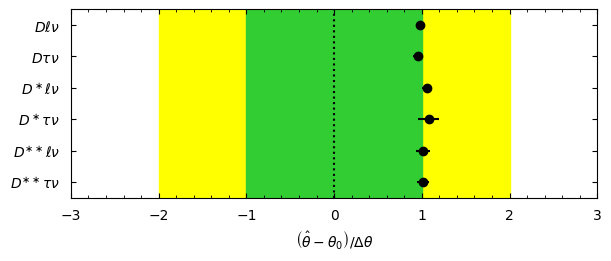

In [29]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


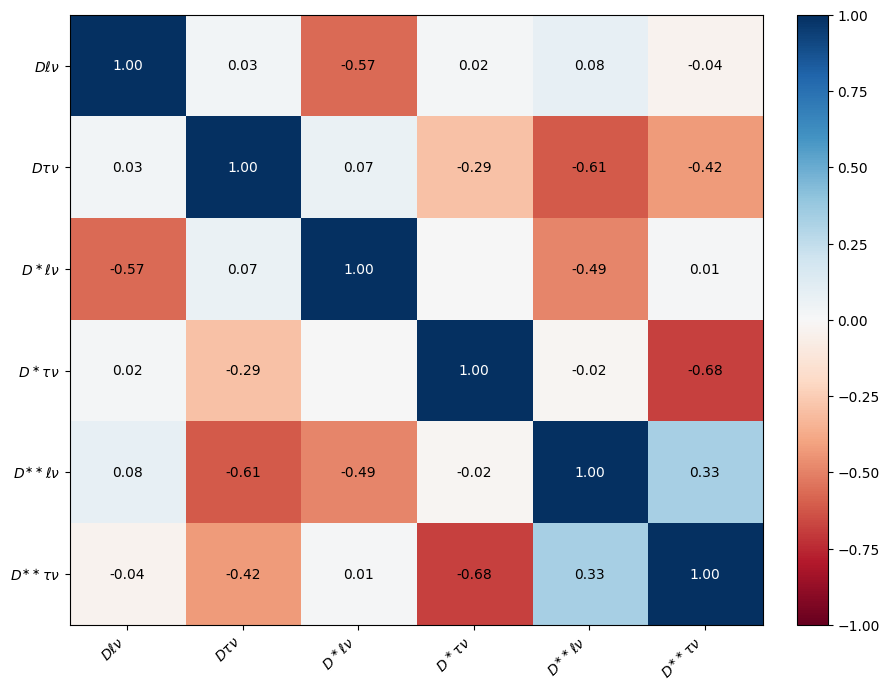

In [30]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.4)

In [31]:
# model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 